# Summary
Our goal is to predict the total number of Washington D.C. bicycle users on an hourly basis using a dataset (use attached `hour.csv`, and have a look at `README.txt` for explanations)
 with data from 2011 and 2012. 
 
 The notebook was divided in the following sections:

-------------------------------------------------------------------------------------------------------------------------------
<a id="index" ></a>
<h1 align="left">
        INDEX
</h1>

* [Setup](#0)
* [1. Exploratory Data Analysis](#1)
    * [1.1. Distribution of initial Features](#2)
    * [1.2. Set Benchmark](#3)
    * [1.3. Bikes Easter Egg](#4)
* [2. Data Engineering](#5)
    * [2.1. Eliminate Redundancy & Initial Data Management](#6)
    * [2.2. Missing Values](#7)
    * [2.3. Create New Features](#8)
    * [2.4. Numerical Variables](#9)
        * [2.4.1. Normalise skewed features](#10)
        * [2.4.2. Outliers Analysis](#11)
    * [2.5. Categorical Variables](#12)
    * [2.6. Feature Selection & Feature Importance](#13)
    
* [3. Machine Learning](#14)
    * [3.1. Train Validation Split](#15)
    * [3.2. Construct the Pipeline](#16)
        * [3.2.1. Column Transformer](#17)
        * [3.2.2. Algorithm Pipeline](#18)
    * [3.3. Train the model with different algorithms/hyperparameters](#19)
* [4. Evaluate the Model](#20)
    * [4.1. Best Performing Model](#21)
    * [4.2. Adjusting Learning Rate with Validation Curve](#22)
    * [4.3. Test the Final Model](#23)

<a id='0'></a>

# Setup

Importing all the relevant libraries we will need to implement our code!

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
%matplotlib inline

#Feature Engineering
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, PowerTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, validation_curve

#Dimensionality reduction
from sklearn.decomposition import PCA

#Regularization
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\timor\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### UDF

In [2]:
# set the date as datetime with UDF, useful for feature creation later
def date_to_datetime (x):
    x = pd.to_datetime(x)
    return x

#Needed to identify if we have missing rows for each day! 24 rows per day should happen but maybe it's not the case!
def missing_rows(dataset, column):
    rows = dataset.loc[:, column].value_counts()
    missing_rows = rows.loc[rows<24]
    return pd.DataFrame(missing_rows)

#This will be used in our pipeline because in this context (1 row = 1 hour) it makes a lot of sense to ffwill.
def forward_fill(data):
    return data.ffill(axis=0, inplace=True)

def number_outliers(data, IQR_num):
    
    """
    Counts the number of outliers that are present in the data per feature
    """
    
    number_outliers = {}
    
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        threshold_upper = Q3 + (IQR_num * IQR)
        threshold_lower = Q1 - (IQR_num * IQR)
        number_outliers[column] = data[
            ((data[column]>threshold_upper) | (data[column]<threshold_lower))
            ][column].count()
    return number_outliers

#This function is used for a specific feature later!
def identify_outliers(data, column, IQR_num):
    
    """
    This function enables to perfrom the Interquartile Range Calculations on the inserted dataset,
    and return not only the number of outliers of the specified feature, but also the index of those on the original dataset
    """
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    threshold_upper = Q3 + (IQR_num * IQR)
    threshold_lower = Q1 - (IQR_num * IQR)

    out_index = data[((data[column] > threshold_upper) | (data[column] < threshold_lower))].index

    number_outliers = data[
        ((data[column]>threshold_upper) | (data[column]<threshold_lower))
        ][column].count()
    return number_outliers, out_index

#The Normal Shapiro test helps to confirm the initial guess about non-normality
def normality_test(dataset, numeric_columns):
    
    for column in numeric_columns:
    
        shapiro = stats.shapiro(dataset[column].dropna(0))

        if shapiro[1]<0.05:

            print(f"The Shapiro Wilk test p-value of {round(shapiro[1], 5)}, therefore {column} is not normally distributed")

        else:
            print(f"The Shapiro Wilk test p-value of {round(shapiro[1], 5)}, therefore {column} is normally distributed")

<a id='1'></a>
[Index](#index)

# 1. Exploratory Data Analysis


We print our dataframe and see that we have approximately 17k rows and 11 columns. We see that most of our data is numerical but we have one feature with strings and one with a date. We also have "instant" which appears to be an ID column and is therefore not going to be useful.

In [3]:
initial_hour_df = pd.read_csv("hour.csv")
initial_hour_df.head(2)

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40


In [4]:
initial_hour_df.set_index("instant", inplace=True)

In [5]:
print(initial_hour_df.shape)

(17379, 10)


In [6]:
# rename the features for easiness

initial_hour_df.rename(columns = {"dteday" : "dateday",
                                  "hr" : "hour",
                                  "weathersit": "weather",
                                  "temp": "temperature",
                                  "atemp" : "feeling_temp",
                                  "hum" : "humidity",
                                  "cnt" : "count",
                                  "windspeed" : "wind_speed",
                                 }, inplace=True)

In [7]:
initial_hour_df["weather"].replace(['Clear, Few clouds, Partly cloudy, Partly cloudy',
                                       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                                      'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
                                      'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'],['Clear/dry','Cloudy/dry','Cloudy/wet','Epicstorm'],inplace=True)


initial_hour_df["weather"] = initial_hour_df["weather"].astype("category")

From the statistical description we can see that our numerical values "temperature", "feeling_temp", "humidity" have been scaled to a value between 0 and 1. Wind_speed also appears to have been scaled however between 0 and 0.85.

In [8]:
initial_hour_df.describe().T

,count,mean,std,min,25%,50%,75%,max
hour,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
temperature,17280.0,0.497071,0.192474,0.02,0.3400,0.5000,0.6600,1.0000
feeling_temp,17279.0,0.475530,0.171782,0.00,0.3333,0.4848,0.6212,1.0000
humidity,17279.0,0.627235,0.193047,0.00,0.4800,0.6300,0.7800,1.0000
wind_speed,17279.0,0.190114,0.122378,0.00,0.1045,0.1940,0.2537,0.8507
casual,17379.0,35.676218,49.305030,0.00,4.0000,17.0000,48.0000,367.0000
registered,17379.0,153.786869,151.357286,0.00,34.0000,115.0000,220.0000,886.0000
count,17379.0,189.463088,181.387599,1.00,40.0000,142.0000,281.0000,977.0000



<a id='2'></a>
## 1.1. Distribution of initial Features

The explore the data distribution we plot the histogram of their values. We one categorical feature (weather) and several ordinal features: hour, month, date. We also see that we have some skewed distributions.

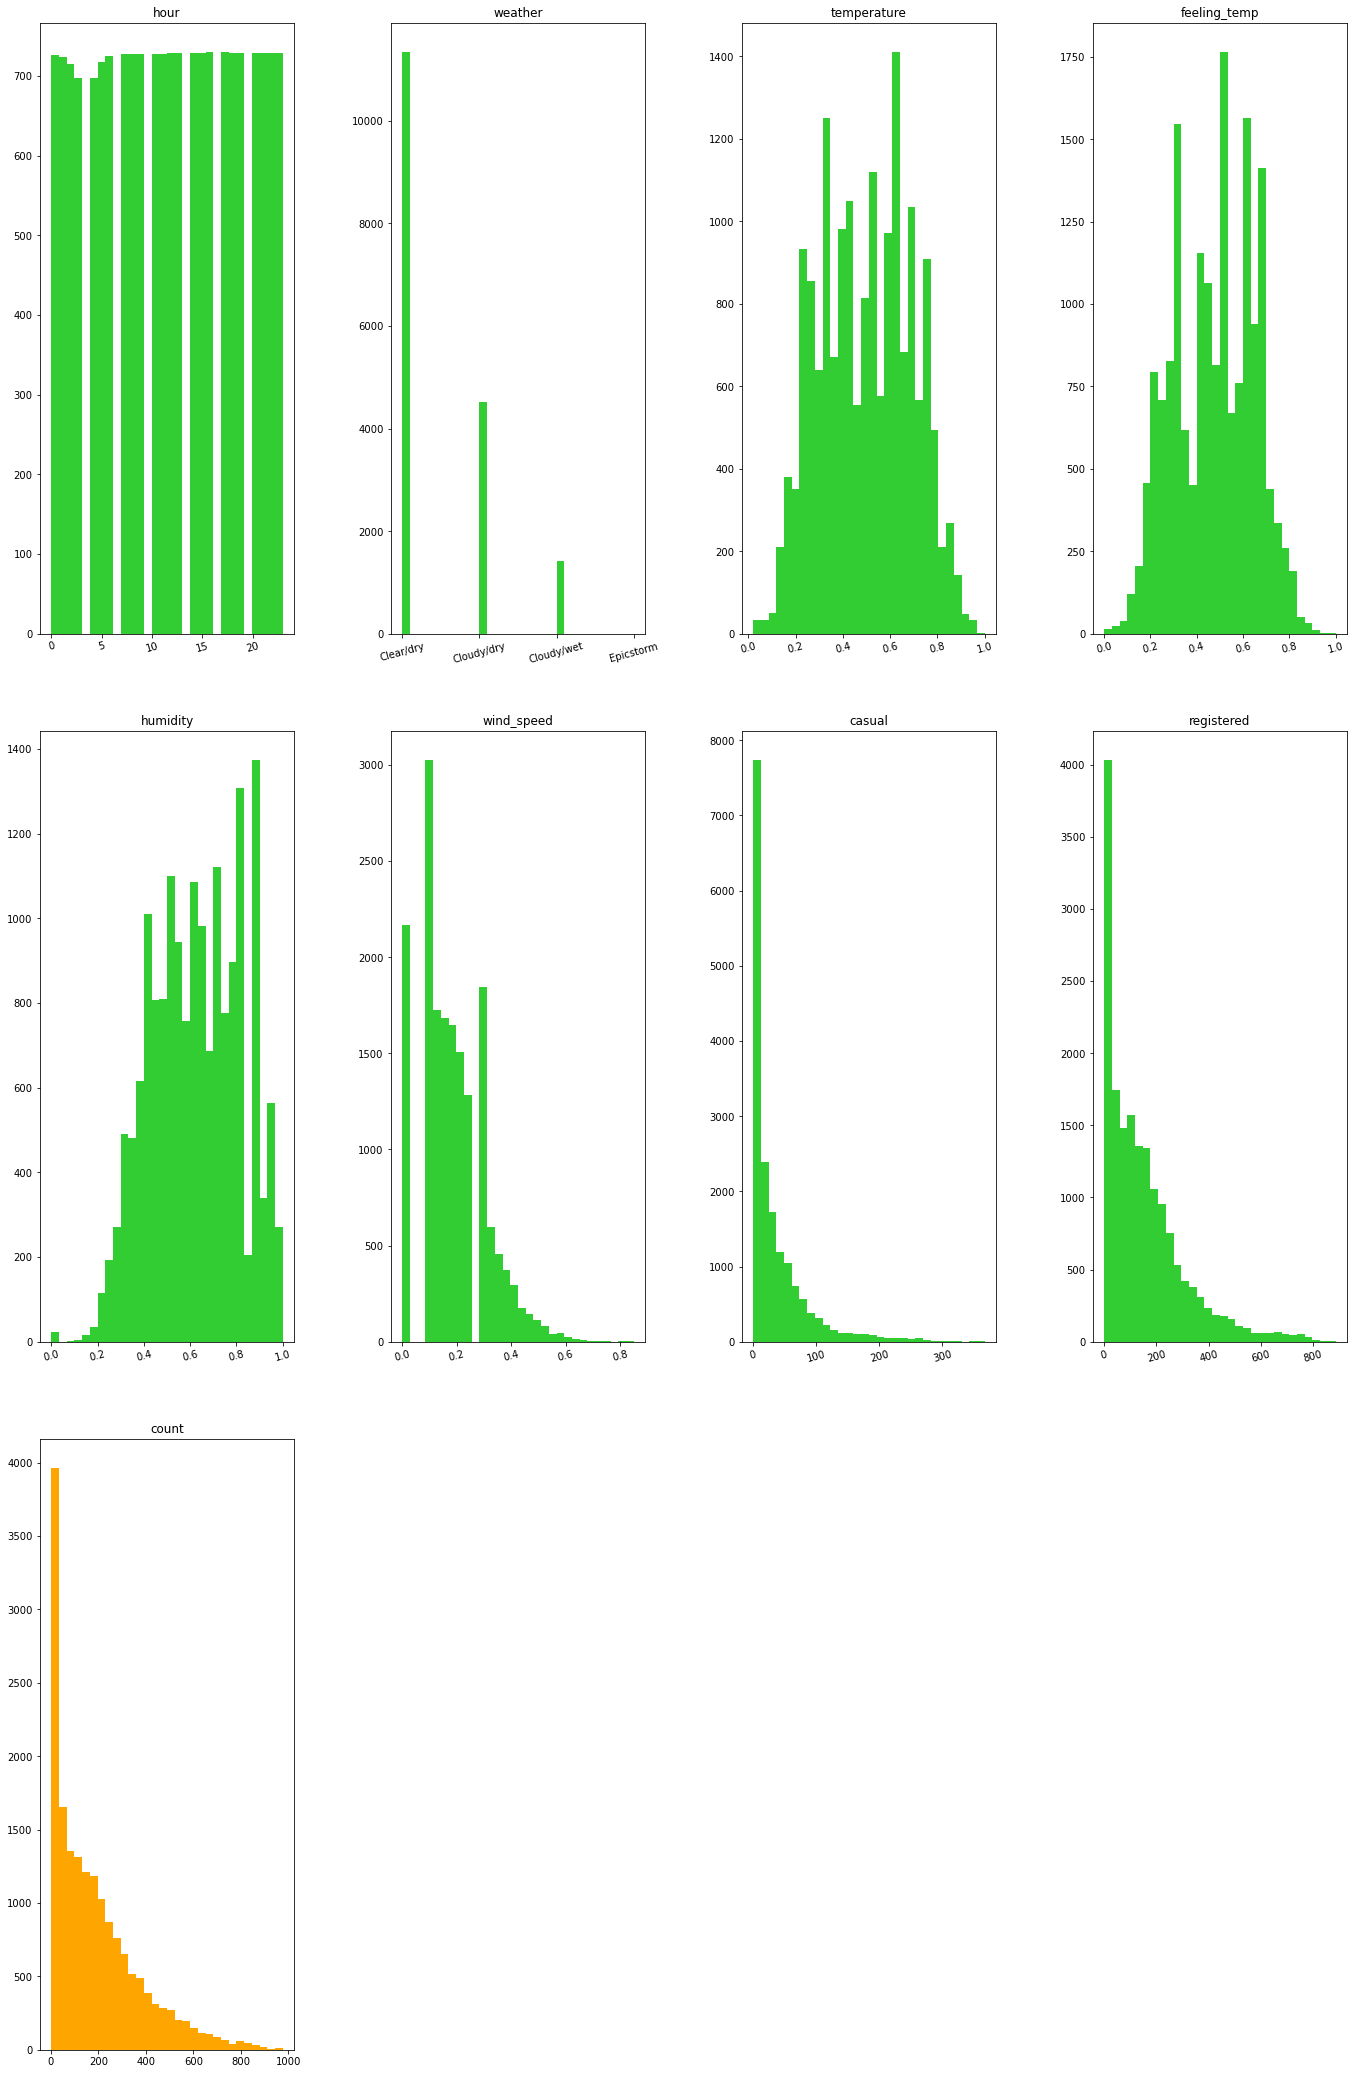

In [9]:
initial_features = initial_hour_df.columns[1:] #we don't want to plot dateday

fig=plt.figure(figsize=(20,30))
columns = 4
rows = 3
fig.tight_layout()

rng_column = zip(range(1, 11), initial_hour_df[initial_features])
for ax, column in rng_column:
    
    fig.add_subplot(rows, columns, ax)
    fig.tight_layout(pad=5)       
    if column == "count":
           plt.hist(initial_hour_df[initial_features].loc[:, column].dropna(0), bins=30, color="orange")
           plt.title(column)
    else:
        plt.hist(initial_hour_df[initial_features].loc[:, column].dropna(0), bins=30, color="limegreen")

        plt.title(column)
        plt.tick_params("x", rotation=15)

plt.show()

Through the correlation matrix we can see that we have some highly correlated features:
   - Temperature and Feeling temperature
   - Casual and Registered with Count, as they are sub-categories
   
Looking at the correlation with "count" we can also get a sense of which features will be useful features in predicting the number of bike rides:
   - **Hour and Temperature** will be useful as they have a strong positive correlation
   - **Humidity** will be useful as it has a strong negative correlation


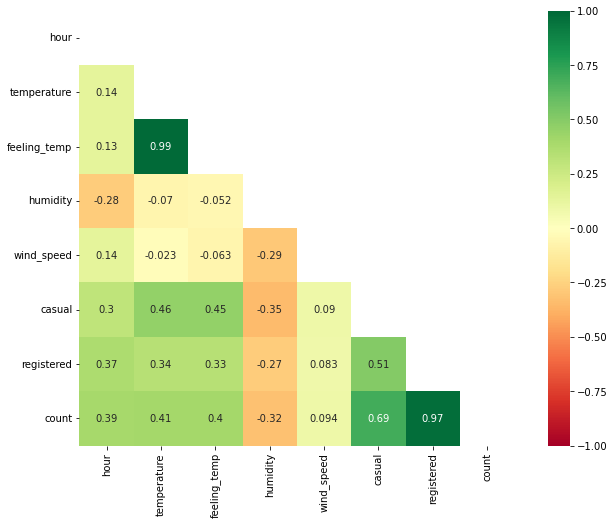

In [10]:
corrmat = initial_hour_df.iloc[:,:11].corr()
mask = np.triu(np.ones_like(corrmat, bool))

f, ax = plt.subplots(figsize = (12,8))
sns.heatmap(corrmat, cmap='RdYlGn', vmax=1, vmin = -1, annot=True, square=True, mask=mask);

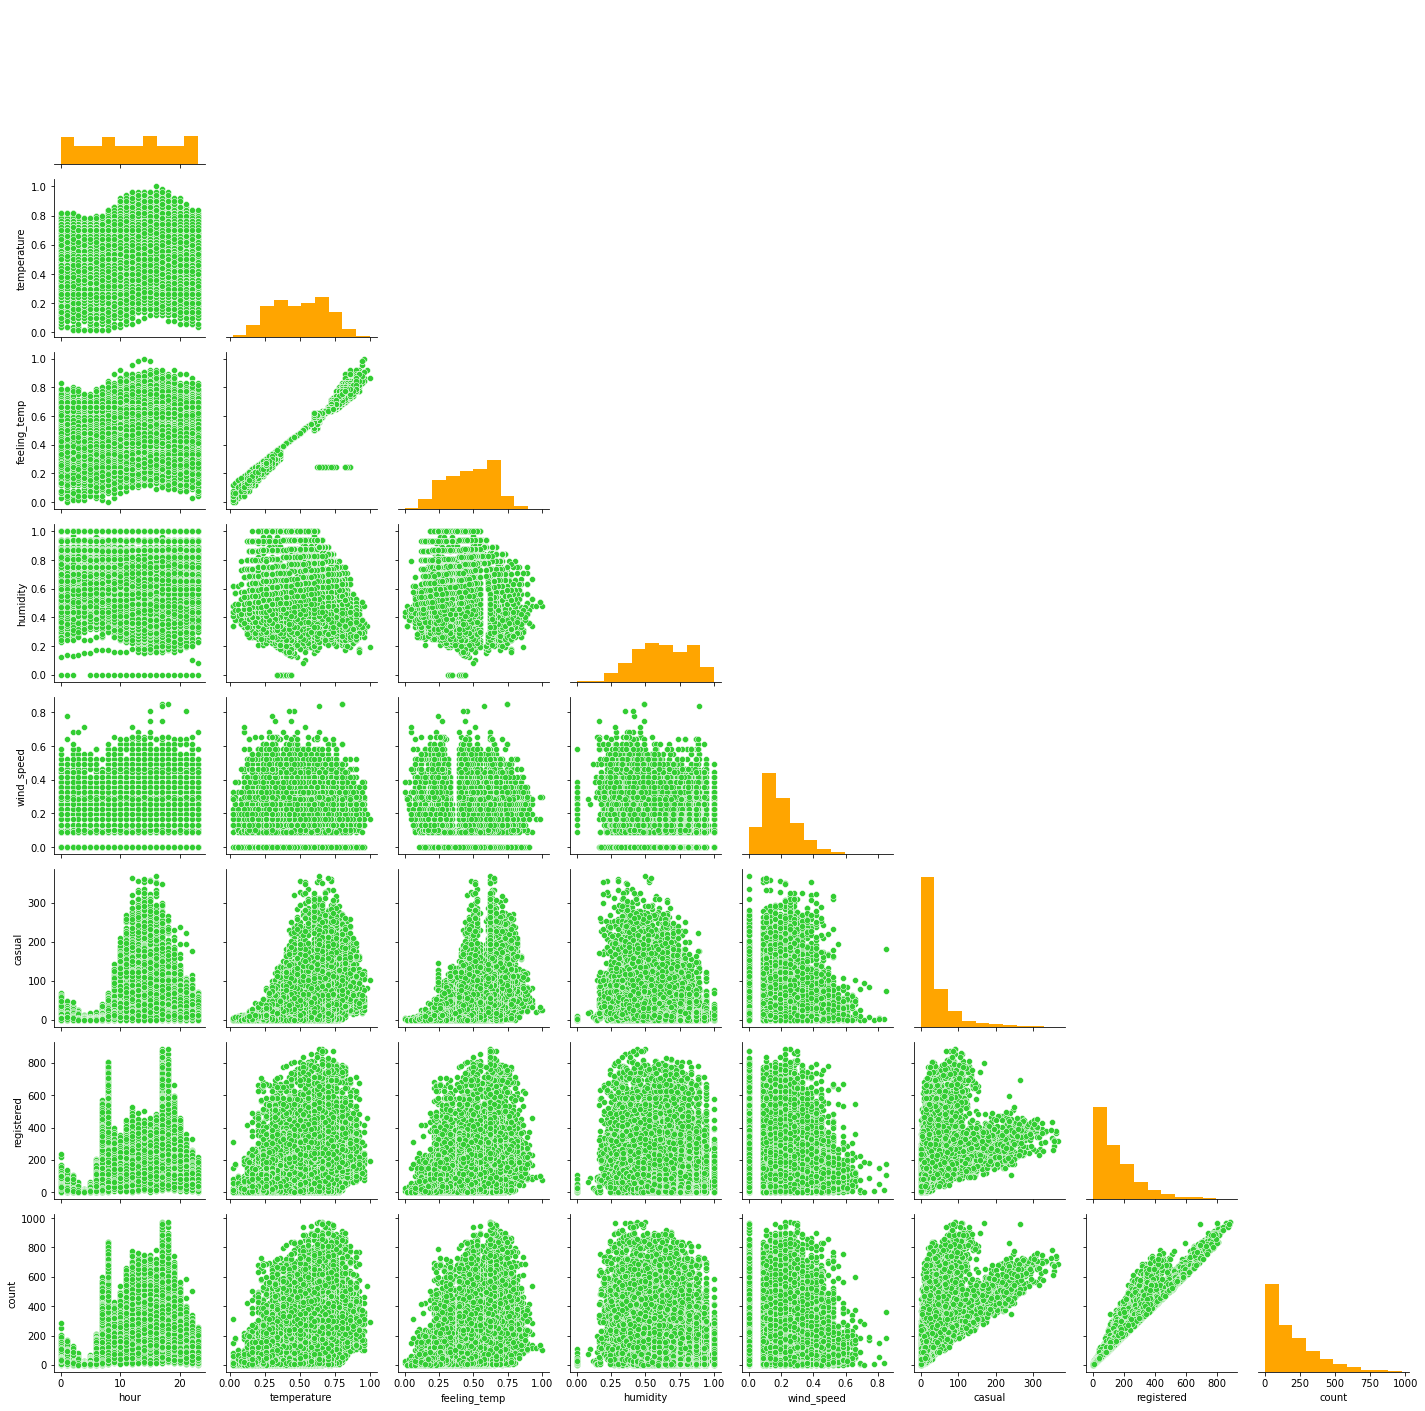

In [11]:
g = sns.PairGrid(initial_hour_df, corner=True)
g.map_lower(sns.scatterplot, color='limegreen')
g.map_diag(plt.hist, color="orange")

<a id='3'></a>
## 1.2. Set Benchmark

We create a benchmark by fitting a linear regression model to the initial dataset in order to later evaluate our data cleaning and feature engineering. 

In [12]:
#Copy the main dataframe for the benchmark on the data in its rawest format
benchmark = initial_hour_df.copy()

In [13]:
benchmark.drop(["registered", "casual"], 1, inplace=True)

In [14]:
benchmark.set_index("dateday", inplace=True)

In [15]:
# encode the weather categorical variable so it can be provided to models

benchmark["weather"].replace(['Clear/dry','Cloudy/dry','Cloudy/wet','Epicstorm'],[0,1,2,3],inplace=True)


benchmark["weather"] = benchmark["weather"].astype("category")

In [16]:
benchmark.dropna(inplace=True)

In [17]:
X = benchmark.loc[:, :].dropna().drop("count", 1)
y = benchmark.loc[:, "count"].dropna() 

With raw data the model has an R2 of 32% and MSE of 56. It's quite bad but it's a starting point!

In [18]:
clf = LinearRegression()
 
# train the model using the training sets
clf.fit(X, y)
 
# regression coefficients
#print('Coefficients: ', clf.coef_)
y_hat = clf.predict(X)
mse = mean_squared_error(y, y_hat)
r_2 = r2_score(y, y_hat)
 
print("RMSE: {}".format(mse**0.5))
print("R^2: {}".format(r_2))

RMSE: 148.53557647185292
R^2: 0.3267733408942368


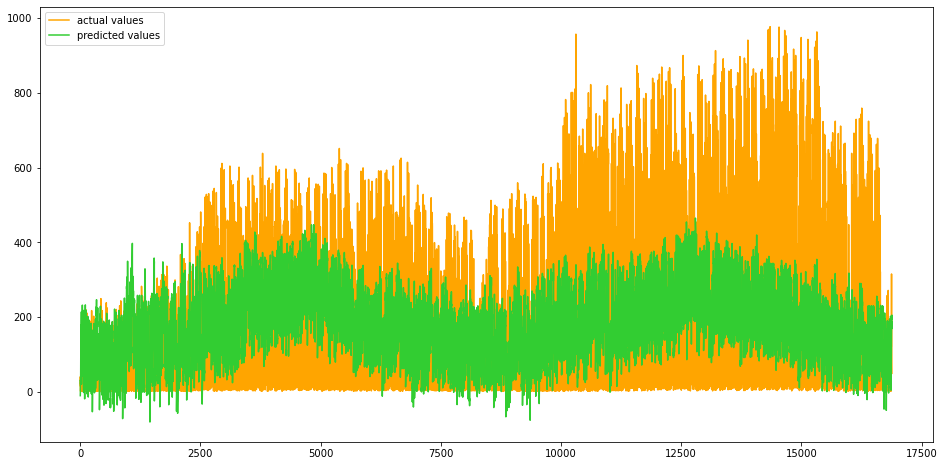

In [19]:
# we plot the predicted vs actual y_train values 

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(y.values, label="actual values", c="orange")
ax.plot(y_hat, label="predicted values", c="limegreen")
ax.legend()
plt.show()

<a id='4'></a>

## 1.3. Bikes Easter Egg

Here we are using the missing rows function of before to identify all the days that do not have 24 rows (24 hours of data) to verify our hypothesis that maybe something happened and data couldn't be collected. We then wanted to check with which frequency did this happen and what were the possible reasons for that.

In [20]:
missing_rows_df = missing_rows(initial_hour_df, "dateday")
missing_rows_df["Missing_values"] = 24-missing_rows_df["dateday"]

In [21]:
missing_rows_df.sort_index(inplace=True)

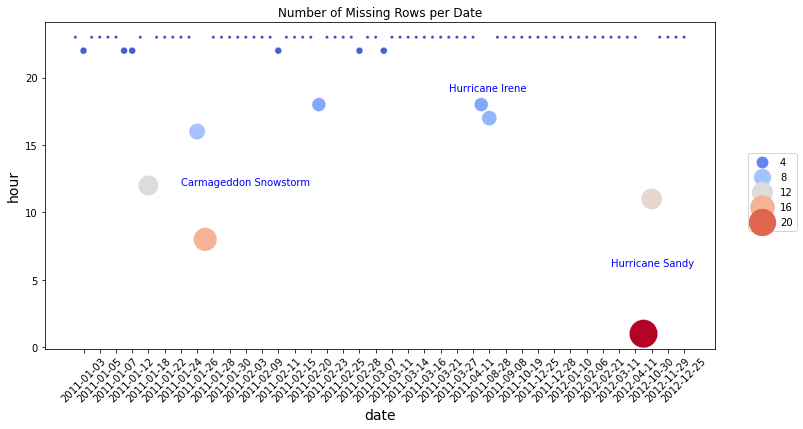

In [22]:
#This is to avoid plotting all the dates on the x axis
x_tick = [i for index, i in enumerate(missing_rows_df.index) if index%2!=0]

#now we plot the amout of missing hours per day!
plt.figure(figsize=(12, 6))
sns.scatterplot(missing_rows_df.index,
                missing_rows_df.loc[:, "dateday"],
                size=missing_rows_df.loc[:, "Missing_values"],
                hue=missing_rows_df.loc[:, "Missing_values"], 
                palette="coolwarm",
                sizes=(10, 800))
plt.ylabel("hour", size=14)
plt.xlabel("date", size=14)
plt.xticks(x_tick, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 0.6), loc='upper left', borderaxespad=0)
plt.text(66, 6, "Hurricane Sandy", color="blue")
plt.text(46, 19, "Hurricane Irene", color="blue")
plt.text(13, 12, "Carmageddon Snowstorm", color="blue")
plt.title("Number of Missing Rows per Date")
plt.show()

#### Finding data inconsistencies

We decided to explore the dataset and find possible days that didn't have a row for every hour indicating a possible problem. Underneath is the code that allowed to extract some interesting insights about natural hazards which impacted bike demand in washington D.C. 
    
**Carmageddon Snowstorm**: from the **18/01/2011** and precisely on the **26/01/2011**, Washington D.C suffered from very instense **Snowstorm** which explains why we are missing rows for that day. [link](https://wtop.com/weather-news/2015/01/history-disastrous-snow-storms-d-c-area/)

**Hurricane Irene**: On the **27/08/2011** and **28/08/2011**, the Atlantic cost was hit by a **hurricane** which produced significant infrastructure damage which can help to explain why many of the rows were missing. [link](https://www.weather.gov/lwx/events_20110827_irene#:~:text=Hurricane%20Irene%20affected%20the%20Mid-Atlantic%20region%20on%20Saturday%2C,just%20before%20affecting%20Puerto%20Rico%20on%20Au-gust%2021st.)

**Hurricane Sandy**: A very powerful **hurricane** hit Washington D.C from the **28/10/2012** to the **2/11/2012** which took the lives of 11 people. This hurricane was the source of 13.55$ million in damages and is the reason why we only have 1 single row on the 29th of October: [link](https://en.wikipedia.org/wiki/Effects_of_Hurricane_Sandy_in_Maryland_and_Washington,_D.C.)

[Index](#index)
<a id='5'></a>
# 2. Data Engineering

We now proceed to data engineering, a key part of a machine learning pipeline. In this section we will remove redundancy, create new features and decide which transformations we will apply to our data. The transformations will be applied with a Column Transformer with our Pipeline.

In [23]:
initial_hour_df.head()

,dateday,hour,weather,temperature,feeling_temp,humidity,wind_speed,casual,registered,count
instant,,,,,,,,,,
1,2011-01-01,0,Clear/dry,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,Clear/dry,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,Clear/dry,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,Clear/dry,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,Clear/dry,0.24,0.2879,0.75,0.0,0,1,1


In [24]:
initial_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   dateday       17379 non-null  object  
 1   hour          17379 non-null  int64   
 2   weather       17279 non-null  category
 3   temperature   17280 non-null  float64 
 4   feeling_temp  17279 non-null  float64 
 5   humidity      17279 non-null  float64 
 6   wind_speed    17279 non-null  float64 
 7   casual        17379 non-null  int64   
 8   registered    17379 non-null  int64   
 9   count         17379 non-null  int64   
dtypes: category(1), float64(4), int64(4), object(1)
memory usage: 1.3+ MB


[Index](#index)
<a id='6'></a>

## 2.1. Eliminate Redundancy & Initial Data Management

Registered and casual are sub-categories of the target, therefore we can drop them.

We will use PCA in our column transformer to remove our highly correlated feature "feeling_temp".

In [25]:
# drop registered and casual

initial_hour_df.drop(["registered", "casual"], 1, inplace=True)

The next step will be to convert the _dateday_ column into a **datetime** format

In [26]:
initial_hour_df.loc[:,"dateday"] = initial_hour_df.loc[:,"dateday"].apply(date_to_datetime)

<a id='7'></a>

## 2.2. Missing Values

These are the Rows that contain at least 1 **NaN** value in it.

In [27]:
initial_hour_df.isnull().sum()

dateday           0
hour              0
weather         100
temperature      99
feeling_temp    100
humidity        100
wind_speed      100
count             0
dtype: int64

We can't identify any pattern regarding these null values as they all don't happen on the same day or on the same hour. Given the data is hourly, an option would be to interpolate. We will fill missing values with a Column Transformer in the pipeline.

In [28]:
# we check if two of the null values columns happen on the same day, they don't
# therefore we can conclude that the null values don't all happen on the same day

pd.DataFrame(initial_hour_df[initial_hour_df["temperature"].isna()][
    "dateday"]).equals(
    pd.DataFrame(initial_hour_df[initial_hour_df[
    "weather"].isna()]["dateday"])) 

False

In [29]:
# we check if there is any pattern in terms of hours and see that there isn't

initial_hour_df[initial_hour_df["wind_speed"].isna()]["hour"].unique()

array([ 9,  0, 10, 22, 16,  4, 23, 15, 17, 20,  1,  5, 11,  6,  8, 14, 12,
       19, 13, 21,  7,  3,  2, 18], dtype=int64)

<a id='8'></a>

## 2.3. Create New Features

We decided to create new features with the given data that could help us to (1) **obtain a better understanding of our data**, and (2) **to obtain more accurate predictions for our regression modelling at a later stage**.

A) **New Ordinal features**

       1) Year: It is possible that from one year to the other the demand for bikes increases/decreases.
   
       2) months: It is likely that some months will have more bike demand based on a more enjoyable weather for biking.
   
       3) week: We wanted to try this feature because we were curious.
   
       4) weekday: Interesting feature very helpful to create other features such as working days or weekend.
   
       5) day: We wanted to try this feature and see what insights we could extract from it.
   
       6) moment of day: It seemed appropriate to distribute into bins the different moments of the day since demand will not be as high during sleeptime (no bike demand), in the early morning (where people go to work) or during at midday (when people are working/enjoying the day).
    
B) **New Categorical features**
       
       7) holiday: we believe that holidays are likely to influence bike demands, which is why we created the feature.
       
       8) seasons: we created the feature because we believe it was likely that bike demand is tied to the season because of the likelihhod to obtain worse wheather in Winter and a better one in summer.
       
       9) workday: We considered relevant to differentiate between the weekdays and the workdays as going to work could increase bike demand.
       
       10) daylight: this feature is based on the assumption that bike demand is associated to the visibility which is why it makes sense to compute it.

Create more **Date** Features from the converted to datetime _dateday_ column.

In [30]:
# create hour, month, day, year, weekday, workday columns 
initial_hour_df["hour"] = initial_hour_df["hour"].astype("object")
initial_hour_df["month"] = initial_hour_df["dateday"].dt.month.astype("object") #Extracts the month of the dateday column
initial_hour_df["day"] = initial_hour_df["dateday"].dt.day.astype("object") #Extracts the day of the dateday column
initial_hour_df["year"] = initial_hour_df["dateday"].dt.year.astype("object") #Extracts the year of the dateday column
initial_hour_df["weekday"] = initial_hour_df["dateday"].dt.weekday.astype("object") #Extracts the month of the weekday column
#Extracts the workday of the dateday column by replacing the values that range from Monday till Friday with 1 (rest with 0).
initial_hour_df["workday"] = initial_hour_df["weekday"].map(lambda x: 1 if x<5 else 0).astype("category")

#### Season Feature

In [31]:
# create season column 

#Define the months for each season
spring = range(3, 6) 
summer = range(6, 9) 
autumn = range(9, 12)
winter = [1, 2, 12]

def season(dataset):
    if dataset["month"] in spring:
        return 2
    elif dataset["month"] in summer:
        return 1
    elif dataset["month"] in autumn:
        return 3
    elif dataset["month"] in winter:
        return 4

# apply season to dataframe
initial_hour_df["season"] = initial_hour_df.apply(season, axis=1).astype("object")
initial_hour_df["season"].value_counts()

1    4403
2    4398
3    4325
4    4253
Name: season, dtype: int64

#### Daylight Feature

In [32]:
# create daylight making assumptions about daylight in Washington DC

warm_daylight = range(6,22) # assume there is daylight from 6 to 9pm in summer/spring
cold_daylight = range(8, 18) # assume there is daylight from 8 to 5pm in autumn/winter

def day_light(dataset):
    if (dataset["hour"] in warm_daylight) and ((dataset["month"] in spring) or (dataset["month"] in summer)):
            return 1
    elif (dataset["hour"] in cold_daylight) and ((dataset["month"] in autumn) or (dataset["month"] in winter)):
            return 1
    else:
            return 0
        
# apply it to dataframe 
initial_hour_df["daylight"] = initial_hour_df.apply(day_light, axis=1).astype("category")
initial_hour_df["daylight"].value_counts()

1    9486
0    7893
Name: daylight, dtype: int64

#### Moments of Day

In [33]:
#Define the time range of hours that define moments of the day
early_morning = [6,7,8]
morning = [9, 10, 11]
lunch_time = [12,13,14]
afternoon = [15,16,17]
return_home = [18,19,20]
dinner_time = [21,22]
home_time = [23, 0, 1, 2, 3, 4, 5]

def moments_of_day(x):
    if x in early_morning:
        return 0
    elif x in morning:
        return 1
    elif x in lunch_time:
        return 2
    elif x in return_home:
        return 3
    elif x in afternoon:
        return 4
    elif x in dinner_time:
        return 5
    elif x in home_time:
        return 6

    
initial_hour_df['moment_of_day'] = initial_hour_df.loc[:, "hour"].apply(moments_of_day).astype("object")
initial_hour_df['moment_of_day'].value_counts()

6    5004
4    2189
2    2186
3    2184
1    2181
0    2179
5    1456
Name: moment_of_day, dtype: int64

#### US Holiday Feature

In [34]:
# create us holiday column importing US Federal Holiday Calendar function

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2011-01-01', end='2012-12-31').to_pydatetime()

def US_Holiday(dataset):
    if dataset["dateday"] in holidays:
        return 1
    else:
        return 0

# apply it to dataframe
initial_hour_df["holiday"] = initial_hour_df.apply(US_Holiday, axis=1).astype("category")
initial_hour_df["holiday"].value_counts()

0    16927
1      452
Name: holiday, dtype: int64

In [35]:
# set new features as categorical

#new_features = ["season", "workday", "holiday", "daylight"]

#for feature in new_features:
    #initial_hour_df[feature] = initial_hour_df[feature].astype("category")

Notice that the features of **hour** | **weekday** |and the **rest of the date features** are considered to be ordinal, and will be handled respectively.

In [36]:
ordinal_features = list(initial_hour_df.select_dtypes(include="object").columns)

In [37]:
categorical_features = list(initial_hour_df.select_dtypes(include="category").columns)

In [38]:
initial_hour_df.dtypes

dateday          datetime64[ns]
hour                     object
weather                category
temperature             float64
feeling_temp            float64
humidity                float64
wind_speed              float64
count                     int64
month                    object
day                      object
year                     object
weekday                  object
workday                category
season                   object
daylight               category
moment_of_day            object
holiday                category
dtype: object

<a id='9'></a>

## 2.4. Numerical Variables

The next step is to assign the correct type to numerical features. Currently dateday and weather are incorrectly set up as strings.

In [39]:
# create a list with the numerical features except hour

numerical_features = initial_hour_df.select_dtypes(include=["int64", "float64"]).columns.drop(["count"])
numerical_features

Index(['temperature', 'feeling_temp', 'humidity', 'wind_speed'], dtype='object')

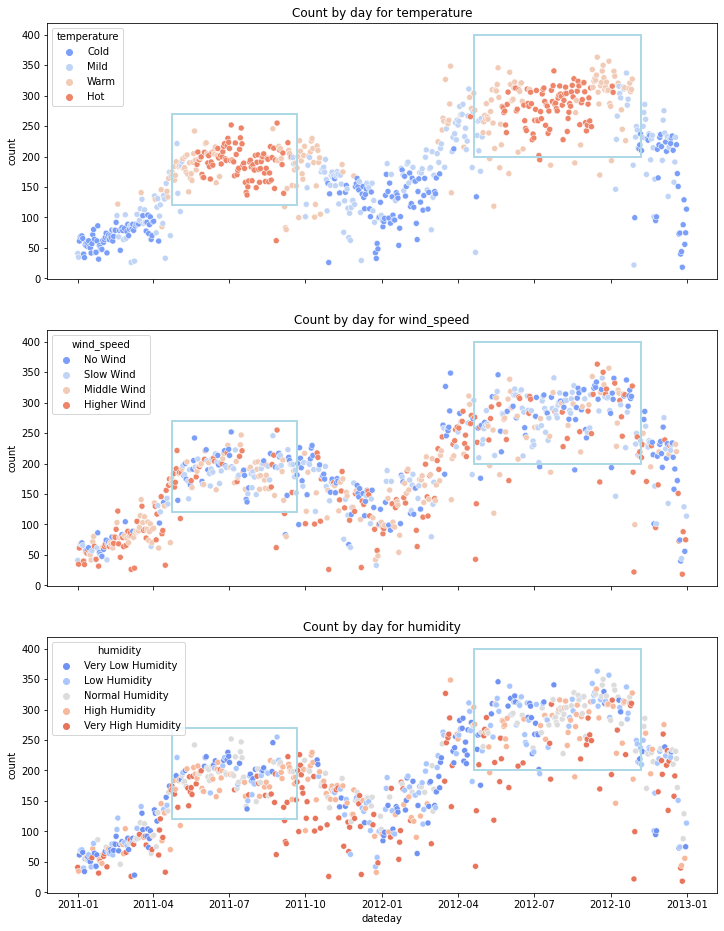

In [41]:
bin_data = initial_hour_df[["temperature", "wind_speed", "humidity", "count", "month", "dateday"]].copy()
bin_data = bin_data.groupby("dateday").mean()

columns = ["temperature", "wind_speed", "humidity"]

for col, value in zip(columns, [41, 67, 100]):
    bin_data[col] = bin_data[col].apply(lambda x: x*value)
 
bin_data["temperature"] = pd.qcut(bin_data["temperature"], 4, labels=["Cold", "Mild", "Warm", "Hot"])
bin_data["wind_speed"] = pd.qcut(bin_data["wind_speed"], 4, labels=["No Wind", "Slow Wind", "Middle Wind", "Higher Wind"])
bin_data["humidity"] = pd.qcut(bin_data["humidity"], 5, labels=["Very Low Humidity", "Low Humidity", "Normal Humidity", "High Humidity", "Very High Humidity"])

fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

for ax, column in zip(axes.ravel(), columns):
    sns.scatterplot(x=bin_data.index, y=bin_data["count"], hue=bin_data[column], palette="coolwarm", ax=ax)
    ax.add_patch( Rectangle((15450, 200),
                        200, 200,
                        fc ='none', 
                        ec ='lightblue',
                        lw = 2))
    ax.add_patch( Rectangle((15088, 120),
                        150, 150,
                        fc ='none', 
                        ec ='lightblue',
                        lw = 2))
    ax.set_title(f"Count by day for {column}")

We see that the distributions of the numerical variables seem not to be normally distributed. However the also see that the mean and the median are almost equal.

In [42]:
initial_hour_df.reset_index(inplace=True)

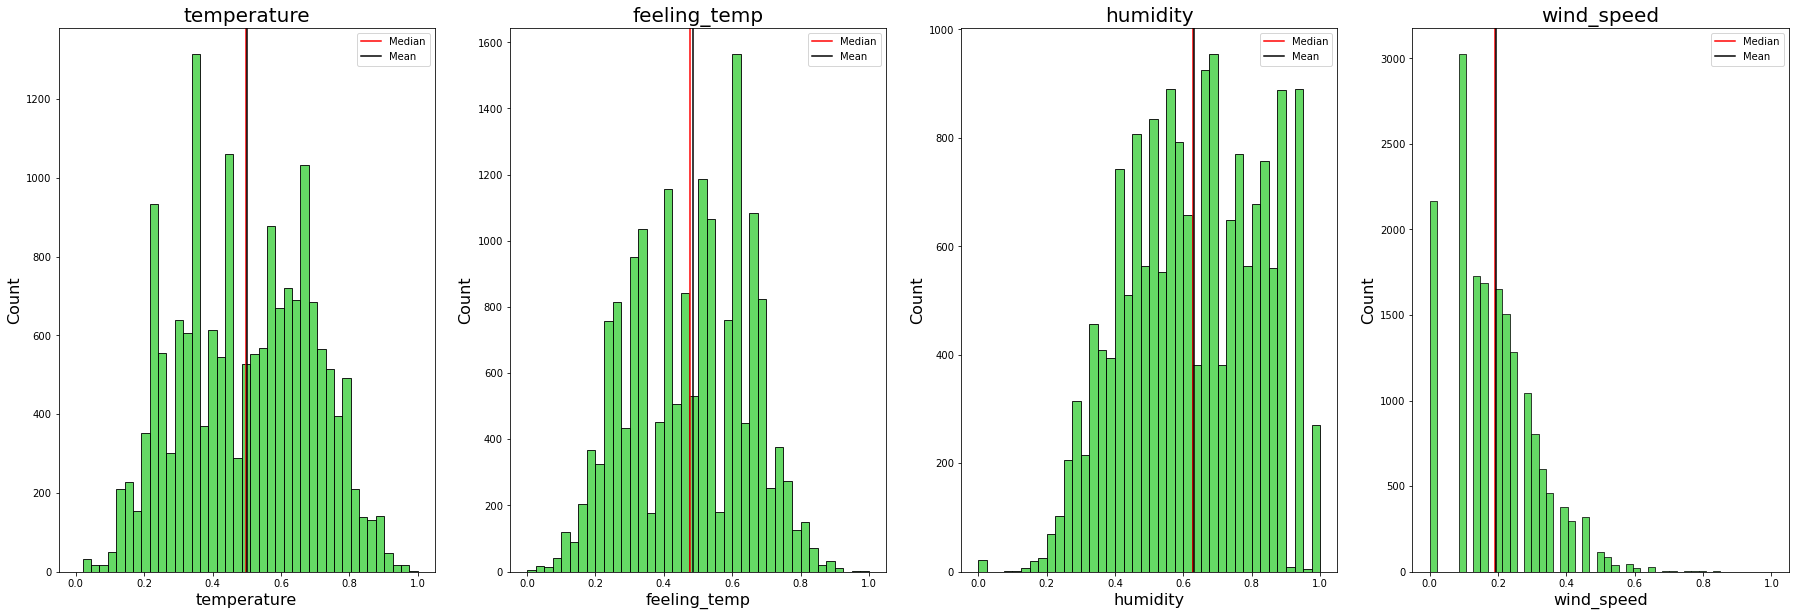

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(31, 10), sharex=True)

for column, ax in zip(numerical_features, axes.ravel()):
    
    sns.histplot(initial_hour_df.loc[:, column], bins=40, color='limegreen', ax=ax)
    ax.set_title(column, size=20)
    ax.axvline(np.mean(initial_hour_df.loc[:, column].dropna(0)), color="red")
    ax.axvline(np.median(initial_hour_df.loc[:, column].dropna(0)), color="black")
    ax.legend(["Median", "Mean"])
    ax.set_xlabel(column, size=16)
    ax.set_ylabel("Count", size=16)

The next step will be to **Normalize** the numerical features so that the outliers can be clearly defined (since there is no domain knowledge that would serve for explainability).

<a id="10" ></a>
### 2.4.1. Normalise skewed features

Many ML algorithms, such as distance based ones, work under the assumption that features follow a normal distribution, therefore we will apply a PowerTransformer to make our data more Gaussian-like. We have applied the Yeo-Johnson method.

In [44]:
normality_test(initial_hour_df, numerical_features)

The Shapiro Wilk test p-value of 0.0, therefore temperature is not normally distributed
The Shapiro Wilk test p-value of 0.0, therefore feeling_temp is not normally distributed
The Shapiro Wilk test p-value of 0.0, therefore humidity is not normally distributed
The Shapiro Wilk test p-value of 0.0, therefore wind_speed is not normally distributed


Now we have certainty through the **formal Shapiro Wilk Test** that the data does not follow a normal distribution.

In [45]:
# apply the PowerTransformer to normalise the data

power = PowerTransformer(method='yeo-johnson', standardize=True)

numerical_trans = power.fit_transform(initial_hour_df[numerical_features])

In [46]:
scaled_numerical = pd.DataFrame(numerical_trans, columns=numerical_features)

The normalised data is not scaled between 0 and 1 anymore, therefore if we apply the PowerTransformer we will need to re-scale our data.

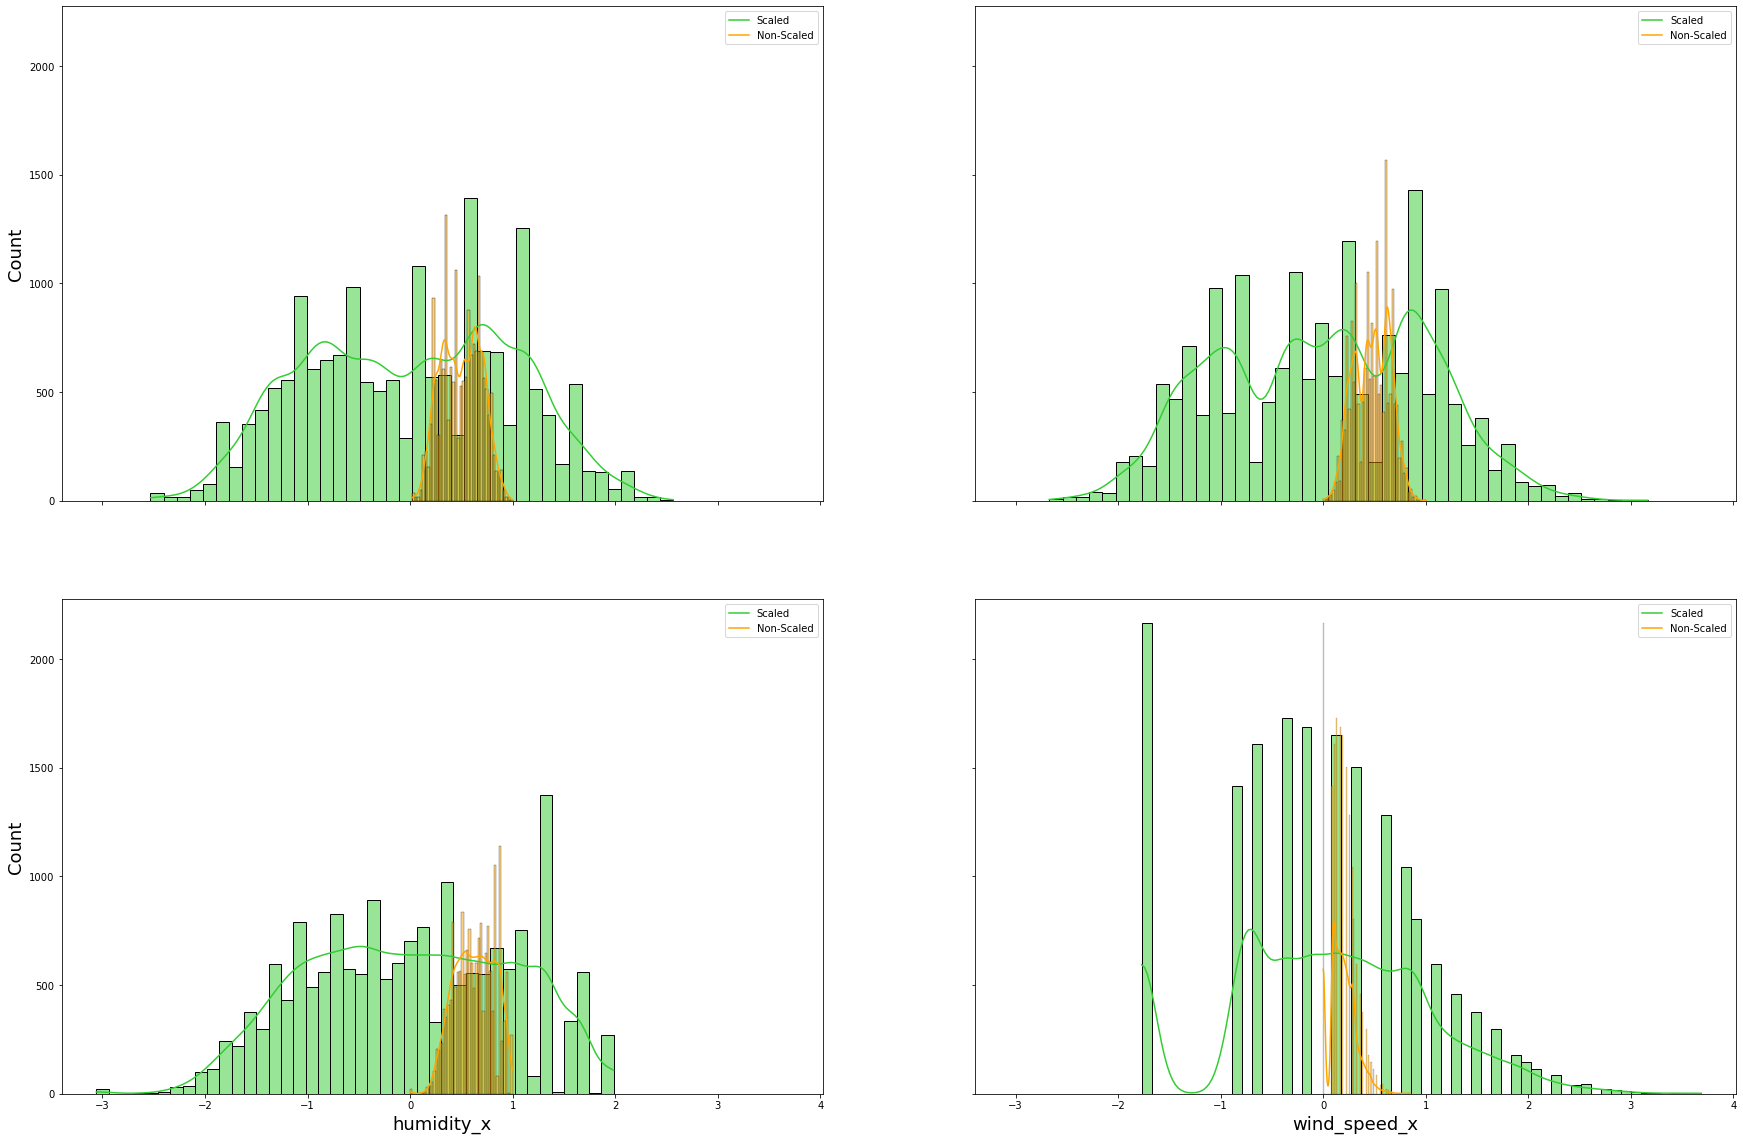

In [47]:
fig, axes = plt.subplots(2, 2, figsize = (30, 20), sharex=True, sharey=True)
before_after_numer_df = pd.merge(scaled_numerical, initial_hour_df[numerical_features], right_index=True, left_index=True)

for ax, scaled, non_scaled in zip(axes.ravel(), before_after_numer_df.columns[:4], before_after_numer_df.columns[4:]):
    sns.histplot(data=before_after_numer_df, x=scaled, color= 'limegreen', label="Non Scaled", kde=True, ax=ax)
    sns.histplot(data=before_after_numer_df, x=non_scaled, color= 'orange', label="Scaled", kde=True, ax=ax)
    ax.legend(["Scaled", "Non-Scaled"])
    ax.set_xlabel(scaled,size=18)
    ax.set_ylabel("Count",size=18)

<a id="11" ></a>
### 2.3.2. Outliers Analysis

We will proceed to investigate the outliers in our initial features for both the original and the normalised data.

#### Outliers on the Original data

After plotting a boxplot of our numerical features and calculating the number of outliers we see that we have 342  in windspeed and 22 in humidity.

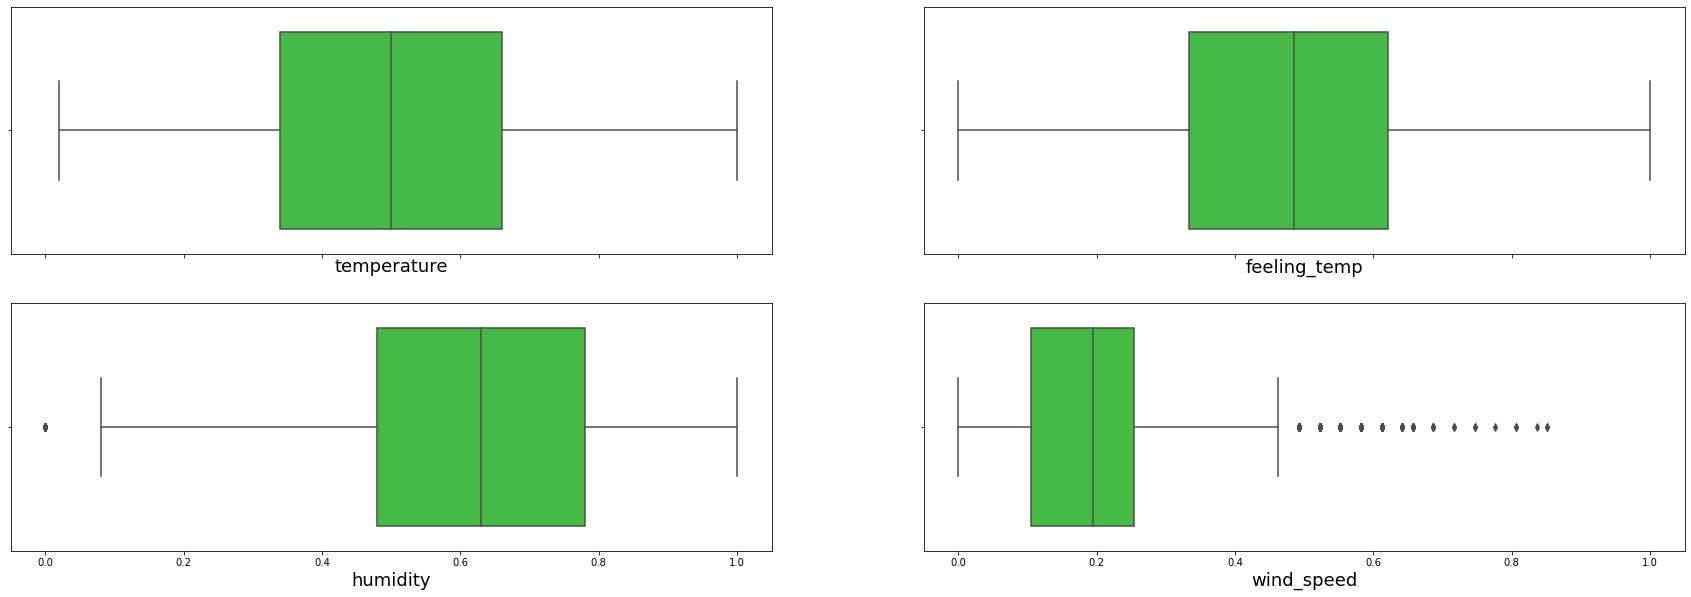

In [48]:
fig, axes = plt.subplots(2, 2, figsize = (30, 10), sharex=True)

for feature, axes in zip(numerical_features, axes.ravel()):
    sns.boxplot(initial_hour_df[feature], ax=axes, color='limegreen')
    axes.set_xlabel(feature,size=18)

In [49]:
# we calculate the number of outliers in original numerical data

number_outliers(initial_hour_df[numerical_features], 1.5)

{'temperature': 0, 'feeling_temp': 0, 'humidity': 22, 'wind_speed': 342}

#### Outliers on the Scaled data

After scaling the data the number outliers reduce but we still have 107 in windspeed. We decide to create a new variable with them given that they are natural outliers and can be explained by the presence of hurricanes and tornados in the US.

In [50]:
# we calculate the number of outliers in scaled numerical data

number_outliers(scaled_numerical, 1.5)

{'temperature': 0, 'feeling_temp': 0, 'humidity': 0, 'wind_speed': 107}

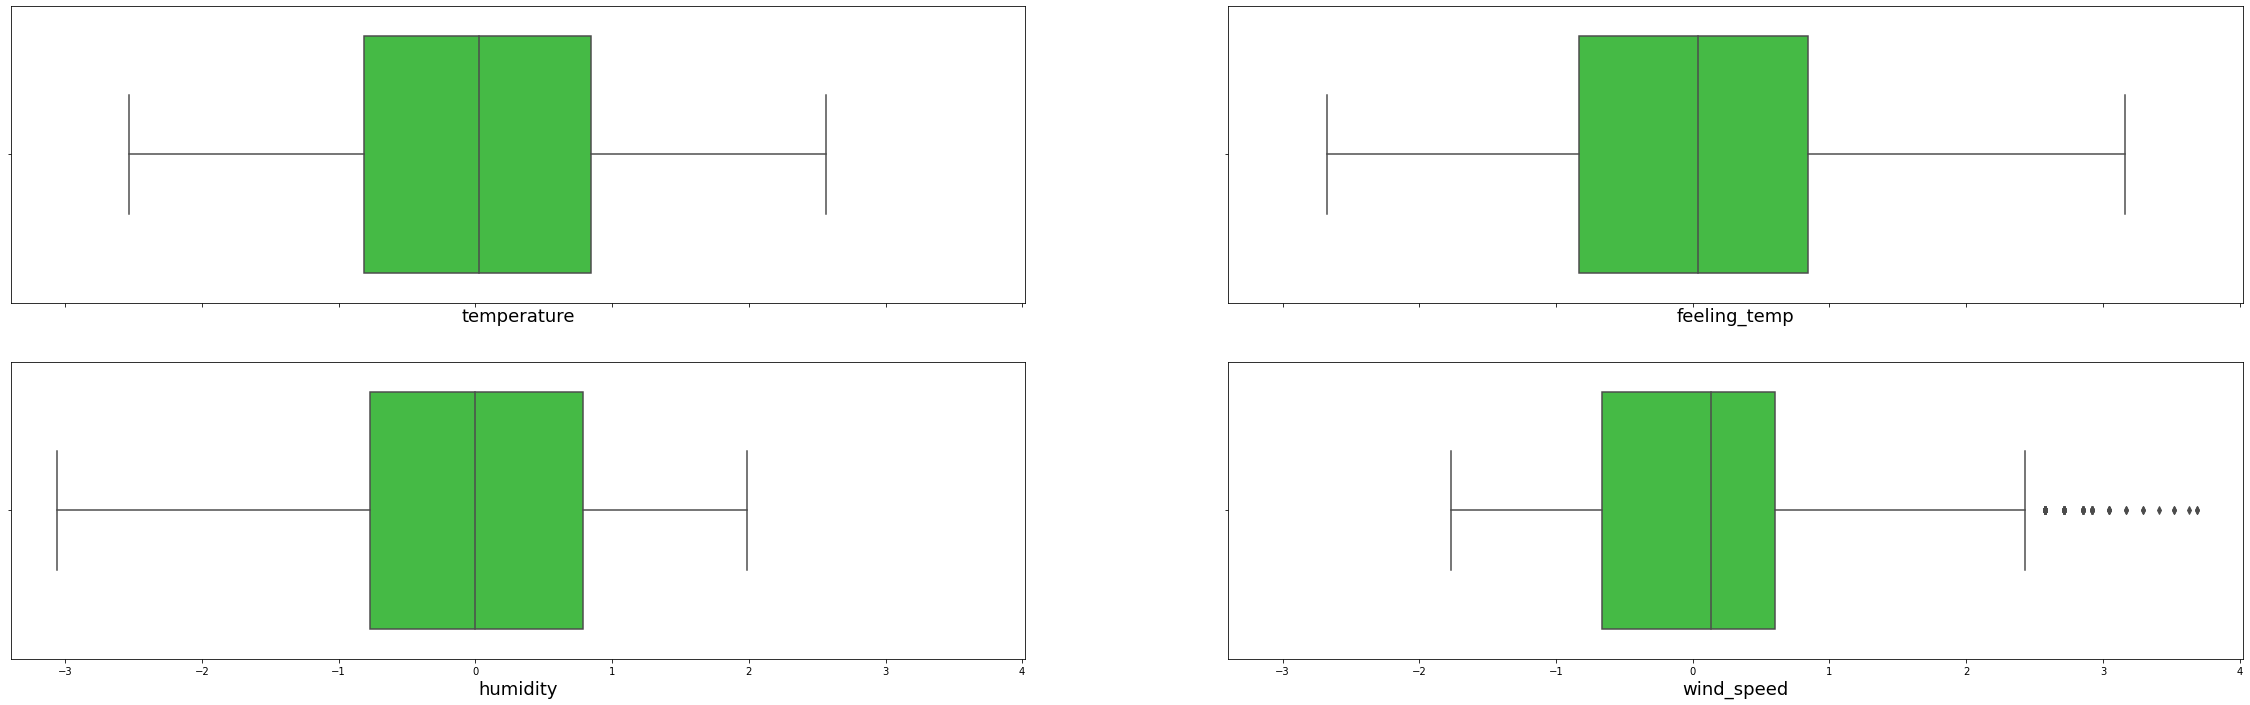

In [51]:
scaled_numerical_features = scaled_numerical.columns

fig, axes = plt.subplots(2, 2, figsize = (40, 12), sharex=True)

for scaled_numerical_features, axes in zip(scaled_numerical_features, axes.ravel()):
    sns.boxplot(scaled_numerical[scaled_numerical_features], ax=axes, color='limegreen')
    axes.set_xlabel(scaled_numerical_features,size=18)

In [52]:
number_outliers(scaled_numerical, 1.5)

{'temperature': 0, 'feeling_temp': 0, 'humidity': 0, 'wind_speed': 107}

In [53]:
# we identify the 107 outliers given it represents < 0.01% of our data 

n_outliers, index_col = identify_outliers(scaled_numerical, "wind_speed", 1.5)

After scaling the data the number outliers reduce but we still have 107 in windspeed.

Given our previous learning from the missing rows, we decided to plot these outliers and see at what time they occured. Then, since we believe that these outliers are associated to faster winds than usual whcih can be explained by natural environmental phenomenons and probably have an impact on count, we decided to create a new feature with the outliers called **strong_wind**.

In [54]:
outliers_column = [1 if i in index_col else 0 for i in range(0, initial_hour_df.shape[0])]

In [55]:
initial_hour_df["strong_wind"] = outliers_column
initial_hour_df["strong_wind"] = initial_hour_df["strong_wind"].astype("category")

In [56]:
initial_hour_df.head(2)

,instant,dateday,hour,weather,temperature,feeling_temp,humidity,wind_speed,count,month,day,year,weekday,workday,season,daylight,moment_of_day,holiday,strong_wind
0,1,2011-01-01,0,Clear/dry,0.24,0.2879,0.81,0.0,16,1,1,2011,5,0,4,0,6,0,0
1,2,2011-01-01,1,Clear/dry,0.22,0.2727,0.80,0.0,40,1,1,2011,5,0,4,0,6,0,0


The feature scaling will be applied inside the Pipeline so that **Dimensionality Reduction** can be applied.

<a id='12'></a>
## 2.5. Categorical Features & Ordinal Features

In [57]:
# encode the weather categorical variable so it can be provided to models

initial_hour_df["weather"].replace(['Clear/dry','Cloudy/dry','Cloudy/wet','Epicstorm'],[0,1,2,3],inplace=True)


initial_hour_df["weather"] = initial_hour_df["weather"].astype("category")

#### Plot against the target

We plot our categorical features, both our original and recently created features, against "count" to understand their relationship with the target.

In [58]:
initial_hour_df.columns[initial_hour_df.dtypes=="category"]

Index(['weather', 'workday', 'daylight', 'holiday', 'strong_wind'], dtype='object')

In [59]:
categorical_features = list(initial_hour_df.columns[initial_hour_df.dtypes=="category"])

In [60]:
categorical_features

['weather', 'workday', 'daylight', 'holiday', 'strong_wind']

In [61]:
ordinal_features

['hour', 'month', 'day', 'year', 'weekday', 'season', 'moment_of_day']

By plotting the categorical variables distribution against the target we can get many useful insights:
   - year: 2012 had way more demand for bikes than 2011, indicating an increasing trend to use bikes.
    - Season: people bike more in summer and autumn, and the least in winter. Again this confims people ride less in cold months. In winter there is also less daylight.
   - Month: the months with the most number of rentals are between May and September.
    - week: we can see that the weeks corresponding to the summer and beggining of autumn months are having the highest amount of bikes used.
   - Day, Weekday: no clear pattern.
   - Hour: the peak hour to rent bikes is in the morning around 8pm or in the afternoon around 5-6pm. This likely indicates that people are biking to work.
   - Holiday: people bike more when there are no holidays, confirming that people are biking to work.
   - Workday: when it's workday there is more bike demand
   - Daylight: people bike a lot more when there is daylight.
   - Weather: the better the weather, the more people rent bikes.
   - Moment of day: there significant differece in the amount of bikes when people from 17-19h when people are going home, and significantly less between 23 and 6 which we labelled as sleeping time.
   - Strongwind: The new created outlier feature is now a categorical feature which has to be analyzed in order to evaluate its effect on the model. 
   

        
As such, we can already expect that **the most useful categorical and ordinal variables** for prediction will be: *Year, Hour, Weather, Month, Season, Moment of day and Daylight*.

#### Categorical & Ordinal Features

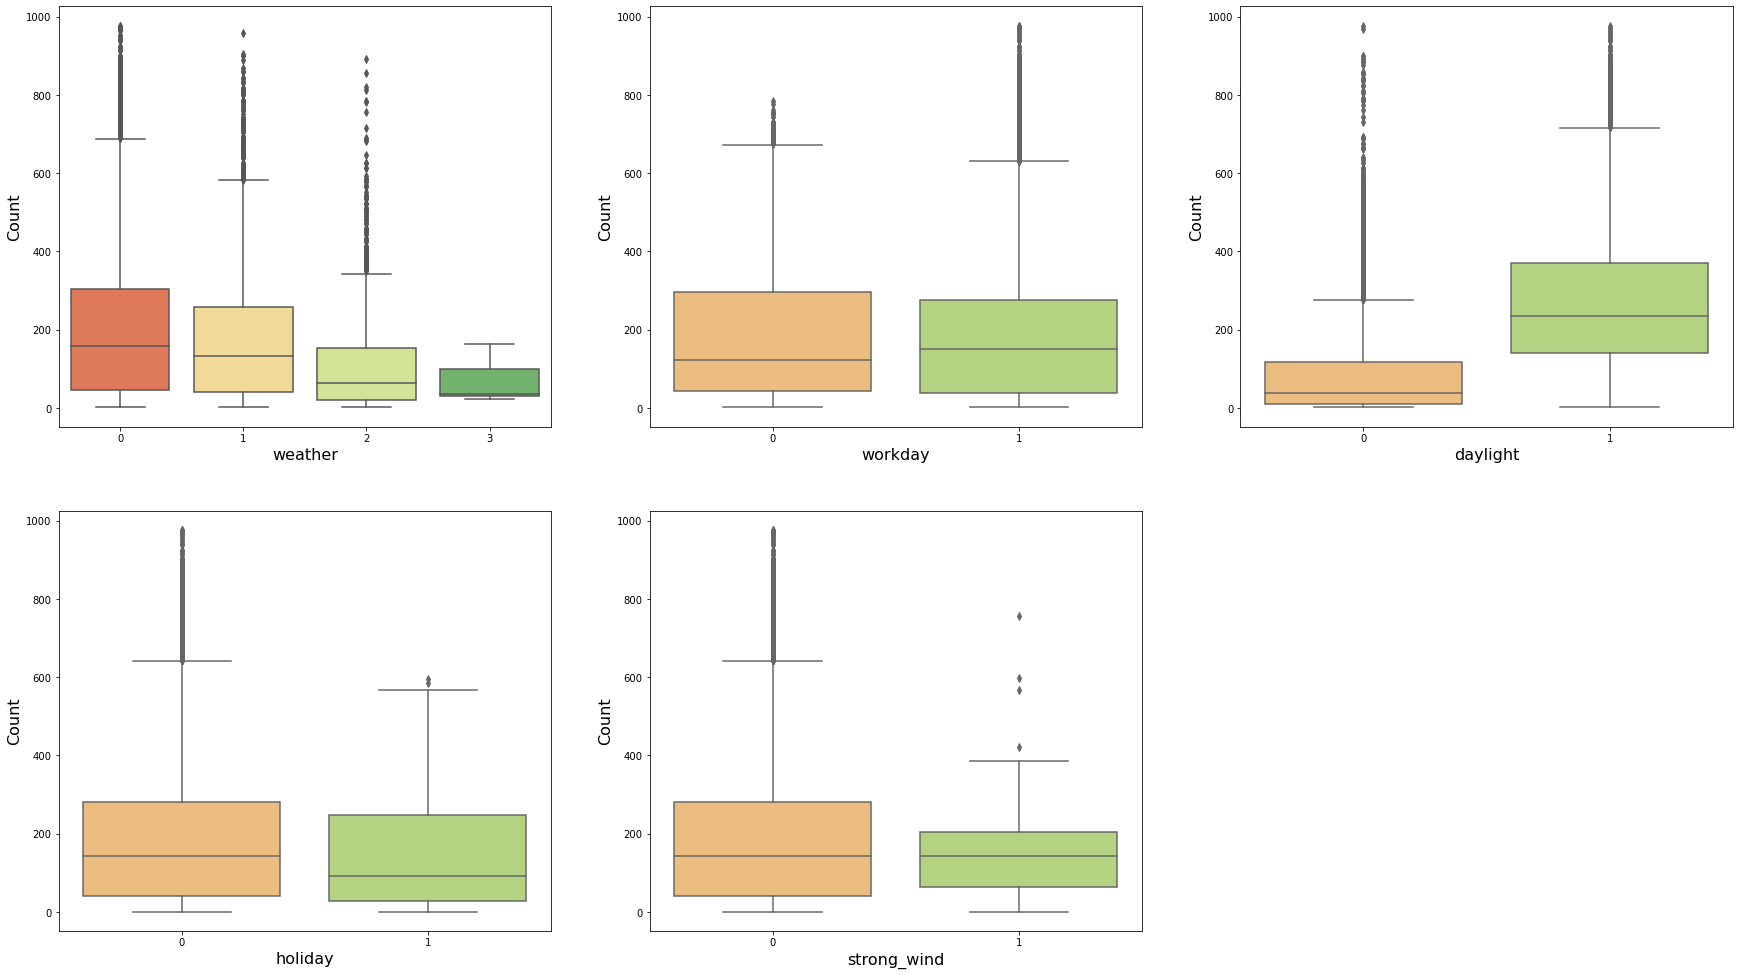

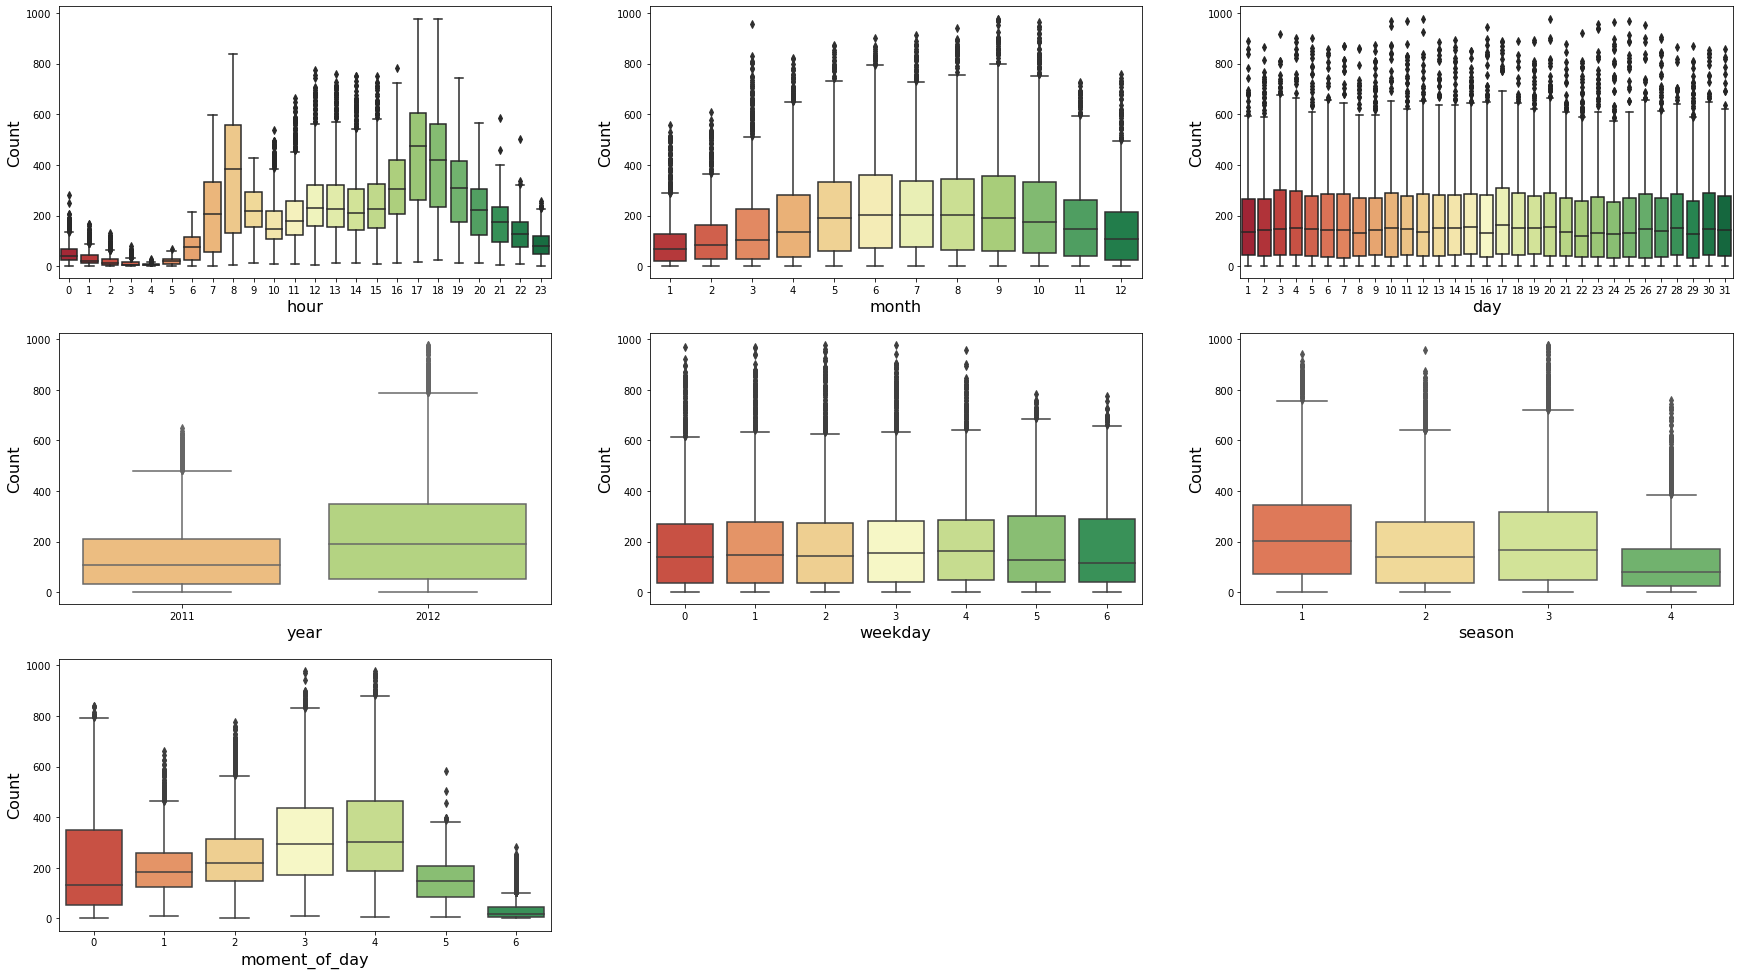

In [62]:
fig, axes = plt.subplots(2, 3, figsize = (30, 17))
fig.delaxes(axes[1][2])
for feature, ax in zip(categorical_features, axes.ravel()):
    sns.boxplot(x=initial_hour_df[feature], y=initial_hour_df["count"],palette="RdYlGn", ax=ax)
    ax.set_xlabel(feature, size=16)
    ax.set_ylabel("Count", size=16)

fig, axes1 = plt.subplots(3, 3, figsize = (30, 17))
fig.delaxes(axes1[2][1])
fig.delaxes(axes1[2][2])
for feature, ax1 in zip(ordinal_features, axes1.ravel()):
    sns.boxplot(x=initial_hour_df[feature], y=initial_hour_df["count"],palette="RdYlGn", ax=ax1)
    ax1.set_xlabel(feature, size=16)
    ax1.set_ylabel("Count", size=16)

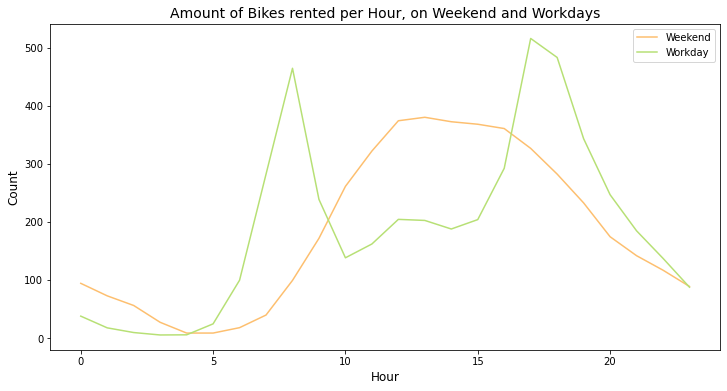

In [63]:
info_plot = initial_hour_df.groupby(["hour", "workday"], as_index=False).mean()

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=info_plot["hour"], y=info_plot["count"], hue=info_plot["workday"], markers=".", palette="RdYlGn")
plt.legend(["Weekend", "Workday"])
plt.title("Amount of Bikes rented per Hour, on Weekend and Workdays", size=14)
plt.xlabel("Hour", size=12)
plt.ylabel("Count", size=12)
plt.show()

<a id="13"></a>
## Feature Selection & Feaure Importance

After carefully crafting our new features and unveiling more insights about our data, we decided to redo the benchmark after our feature analysis, with the hope that our features enabled the model to improve its predictive accuracy. 

In [64]:
benchmark_after_feature_engineering = initial_hour_df.copy()

benchmark_after_feature_engineering = benchmark_after_feature_engineering.dropna()

X = benchmark_after_feature_engineering.loc[:].drop(["count", "instant", "dateday"], 1)
y = benchmark_after_feature_engineering.loc[:, "count"]

In [65]:
clf = LinearRegression()
 
# train the model using the training sets
clf.fit(X, y)
 
# regression coefficients
#print('Coefficients: ', clf.coef_)
y_hat = clf.predict(X)
mse = mean_squared_error(y, y_hat)
r_2 = r2_score(y, y_hat)
 
print("RMSE: {}".format(mse**0.5))
print("R^2: {}".format(r_2))

RMSE: 126.14653305890184
R^2: 0.5144309788830208


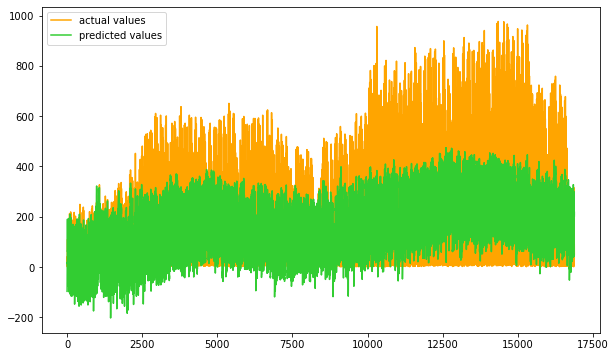

In [66]:
# we plot the predicted vs actual y_train values 

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y.values, label="actual values", c="orange")
ax.plot(y_hat, label="predicted values", c="limegreen")
ax.legend()
plt.show()

In [67]:
feature_importance = pd.DataFrame({"Features":X.columns, "Coefficient":clf.coef_}).sort_values("Coefficient", ascending=False)

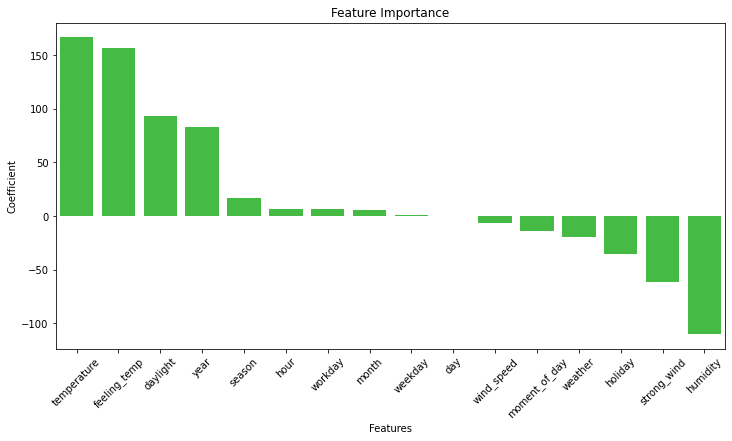

In [68]:
plt.figure(figsize=(12, 6))

sns.barplot(x=feature_importance["Features"], y=feature_importance["Coefficient"], color="limegreen")
plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

Looking at the feature importance, there can be clearly seen that _day_ can be dropped from the dataframe:

The **most valuable features** for predictions were *temperature and feeling temperature, daylight, humidity, year, season, strong wind and holiday*. Additionally, we can actually see that weekday is not as relevant to predict demand, but the feature was useful to compute other features, therefore, now, we will drop it.

In [69]:
initial_hour_df.drop(["day"], 1, inplace=True)

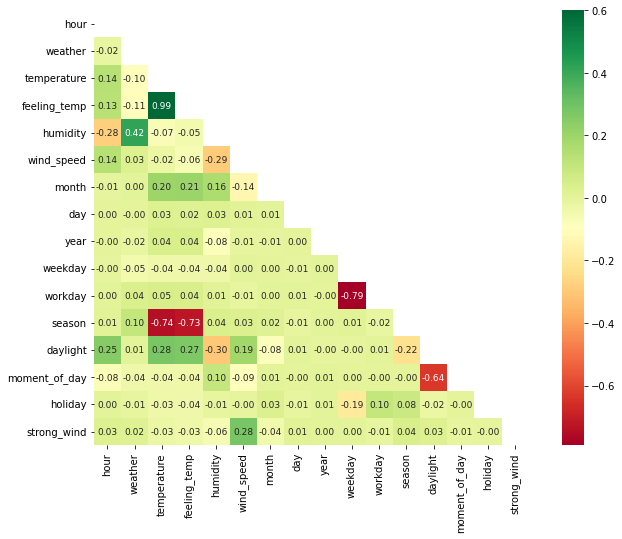

In [70]:
X = X.astype("float")
corrmat = X.iloc[:,:].corr()
mask = np.triu(np.ones_like(corrmat, bool))

f, ax = plt.subplots(figsize = (12,8))
sns.heatmap(corrmat, cmap='RdYlGn', vmax=0.6, annot=True,fmt=".2f", square=True, mask=mask, annot_kws={"size": 9});

We can see that after designing new features, **R^2 increase by 0.2** (from **0.32** to **0.51**) indicating that our features noticeably enhance predictability of the model. 

Now we will proceed with the Machine Learning modelling and split into train and test.

In [71]:
initial_hour_df.isna().sum()

instant            0
dateday            0
hour               0
weather          100
temperature       99
feeling_temp     100
humidity         100
wind_speed       100
count              0
month              0
year               0
weekday            0
workday            0
season             0
daylight           0
moment_of_day      0
holiday            0
strong_wind        0
dtype: int64

[Index](#index)
<a id='14'></a>

# 3. Machine Learning

<a id='15'></a>
## 3.1. Train Validation Split

We split the dataset into a train and test set. 

In [72]:
initial_hour_df.set_index("dateday", inplace=True)

In [73]:
initial_hour_df.drop(["instant"], 1, inplace=True)

In [74]:
train = initial_hour_df.loc[:"2012-10-01"]
test = initial_hour_df.loc["2012-10-01":]

In [75]:
y_train = train['count']
y_test = test['count']

In [76]:
x_train = train.drop("count", 1)
x_test = test.drop("count", 1)

In [77]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15235, 15)
(2168, 15)
(15235,)
(2168,)


<a id='16'></a>
## 3.2. Construct the Pipeline

In this part of the study the focus will rely on the **hyperparameters** and the **machine learning algorithms** that will allow to fit even better the data and give much more reliable predictions.

We proceed to construct our pipeline and apply all the transformations that we have decided based on our exploration of the data.

In [78]:
# let's first separate features

categorical_features = list(initial_hour_df.select_dtypes(include=["category"]).columns)
ordinal_features = list(initial_hour_df.select_dtypes(include=["object"]).columns)
numerical_features = list(initial_hour_df.select_dtypes(include=["int64", "float64"]).columns.drop(["count"]))

print(f"Categorical features: {categorical_features}")
print(f"Ordinal features: {ordinal_features}")
print(f"Numerical features: {numerical_features}")

Categorical features: ['weather', 'workday', 'daylight', 'holiday', 'strong_wind']
Ordinal features: ['hour', 'month', 'year', 'weekday', 'season', 'moment_of_day']
Numerical features: ['temperature', 'feeling_temp', 'humidity', 'wind_speed']


We build our pipeline we apply the following:
    
   - Categorical Features:
       - We create dummy variables for them
   -  Ordinal Features:
       - We encode year, hour, month, day, moment of the day and weekday as ordinal as they have a natural order.
   -  Numerical Features:
       - We fill the missing values with the mean as it is almost equal to the mean (even though the formal test shows the lack of normality on the numerical features).
       - Since there is correlation between some of the variables, as seen in the previous **correlation matrix**, **Principal Component Analaysis** can be applyed on this features as it will get rid of the high complexity of the model.

<a id='17'></a>
### 3.2.1. Column Transformer

In [79]:
# define categorical pipeline
cat_pipe = Pipeline([
    ("imputer", FunctionTransformer(inverse_func=forward_fill)),
    ("encoder", OneHotEncoder())
])

# define ordinal pipeline
ord_pipe = Pipeline([
    ("encoder", OrdinalEncoder())
])

# define numerical pipeline
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("pca", PCA())
])

# create the preprocessor with all the transformations
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("ord", ord_pipe, ordinal_features),
    ("num", num_pipe, numerical_features)
], remainder = 'drop')

<a id='18'></a>
### 3.2.2. Algorithm Pipeline

Since there are some features that still remain **skewed** as there are different types of data, and the tranformations will not convert those into _Gaussian shapes_ the followed approach was to exclude the _Linear Based_ algorithms and focus more on the **Tree Based** models that are less sensitive to different types of data.

The selected algorithms are:

- Decision Tree Regressor
- Random Forest Regressor
- XGBoost Regressor
- Gradient Boosting Regressor
- ExtraTreesRegressor


<font size="0.3">*Note: the benchmark algorithm, Linear Regression, will also be included for comparison purposes</font>

In [80]:
# define the algorithms that we will use 

lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xg = XGBRegressor()
gb = GradientBoostingRegressor()
xtt = ExtraTreesRegressor()

In [81]:
# we define the different parameters that we will want to try in our algorithms

params1= {}

params2= {"model__max_depth":[None, 1]}

params3= {"model__n_estimators":[10, 20],
          "model__min_samples_split":[2, 5]}

params4= {}

params5= {"model__learning_rate":[0.01, 0.05]}

params6 = {}


In [82]:
# create a dictionary with the algorithms and list of parameters

regr = {"LinReg":lr, 
        "DecisionTree": dt,
        "RandomForest":rf,  
        "XGBoost":xg, 
        "GradientBoost":gb,
        "ExtraTrees": xtt,
}
params = [params1, params2, params3, params4, params5, params6]

<a id='19'></a>

## 3.3 Train the model with different algorithms/hyperparameters

Our task is to predict the number of bikes that will be rented at a point in time. We are predicting a discrete output therefore we will use Regression models.

In [83]:
# for loop that applies our pipeline transformations with each 
# logarithm, fits using x_train and y_train 
# predicts y_test using x_test  
# and calculates the R2 and RMSE

result = {}

for model, parameter in zip(regr.keys(), params):  
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model",regr[model])
    ])

    search = GridSearchCV(pipe, parameter, cv=10, n_jobs=-1) #cv 10 as we have a large number of rows

    search.fit(x_train, y_train)

    pred = search.predict(x_test)

    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{model} R^2 (coef. det.): {round(r2, 4)}")
    result[model] = {"R 2": r2, 
                     "RMSE": mse**0.5,
                     "Best Params": search.best_params_,
                     "Predictions": pred}

LinReg R^2 (coef. det.): 0.4234
DecisionTree R^2 (coef. det.): 0.7959
RandomForest R^2 (coef. det.): 0.8211
XGBoost R^2 (coef. det.): 0.8557
GradientBoost R^2 (coef. det.): 0.3676
ExtraTrees R^2 (coef. det.): 0.8675


We will now use the x_test to predict y_test in order to evaluate how our model performs with unseen data. We apply cross-validation to ensure robustness of our results.

The best performing model based on the R2 is the **XGBoost with an R2 of 0.8557**. This means our model explains **85.57%** of the variability in the number of bike rentals. An RMSE of **79.5** means on average we overstimate or underestimate the number of rentals by **79.5** bikes.

In [84]:
result = pd.DataFrame(result).T
result.iloc[:5]

,R 2,RMSE,Best Params,Predictions
LinReg,0.423409,153.071509,{},"[95.38153913014429, 91.11534389234285, 107.500..."
DecisionTree,0.795921,91.066675,{'model__max_depth': None},"[45.0, 18.0, 12.0, 7.0, 10.0, 36.0, 155.0, 483..."
RandomForest,0.821064,85.272443,"{'model__min_samples_split': 2, 'model__n_esti...","[60.1, 18.0, 11.5, 7.1, 7.9, 39.3, 158.7, 492...."
XGBoost,0.85567,76.584119,{},"[50.82226, 20.638657, 11.240992, 15.097635, 15..."
GradientBoost,0.367631,160.304405,{'model__learning_rate': 0.01},"[87.45717626071172, 82.89175063325776, 82.4200..."


In [85]:
result.loc["XGBoost", "Best Params"]

{}

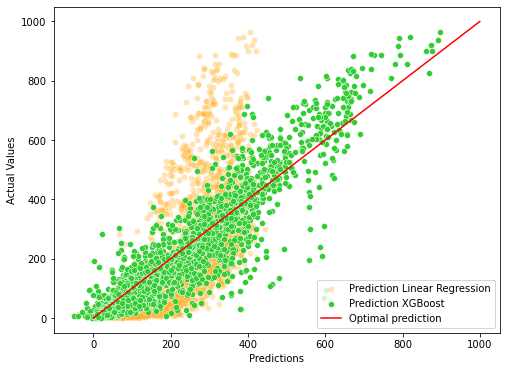

In [86]:
plt.figure(figsize=(8,6))
line = list(range(0, 1200, 200))

sns.scatterplot(x=result.loc["LinReg", "Predictions"], y=y_test, color='orange', alpha=.3)
sns.scatterplot(x=result.loc["XGBoost", "Predictions"], y=y_test, color="limegreen")
plt.plot(line, line, color="red")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.legend(["Prediction Linear Regression", "Prediction XGBoost", "Optimal prediction"])

[Index](#index)

<a id="20" ></a>
# 4. Evaluate the Model 

The best model to predict bikes demand was XGBboost with the best parameters being {*model_learning_rate:.09*} leading to **R^2 = 0.85, and **RMSE = 75.7**. 

Having that in mind we decided to retrain our model to extract further insights, find the feature importance, create a matrix and plotting actual vs predicted values nicely.

<a id="21" ></a>
## 4.1. Best Performing Model

In [87]:
x_train_trans = preprocessor.fit_transform(x_train)
x_test_trans = preprocessor.transform(x_test)

In [88]:
xg = XGBRegressor(learning_rate=0.09,min_child_weight=10,n_estimators=150, gamma=10)

xg.fit(x_train_trans, y_train)

y_hat = xg.predict(x_train_trans)

# we obtain the performance metrics:
mse = mean_squared_error(y_train, y_hat)
r_2 = r2_score(y_train, y_hat)
 
print("Root RMSE on training set: {}".format(mse**0.5))
print("R^2 on training set: {}".format(r_2))

Root RMSE on training set: 34.388277213925775
R^2 on training set: 0.9626994636354707


In [89]:
y_hat_new = xg.predict(x_test_trans)

# we obtain the performance metrics:
mse = mean_squared_error(y_test, y_hat_new)
r_2 = r2_score(y_test, y_hat_new)
 
print("Root RMSE on test set: {}".format(mse**0.5))
print("R^2 on test set: {}".format(r_2))

Root RMSE on test set: 75.46854720108085
R^2 on test set: 0.8598440969497246


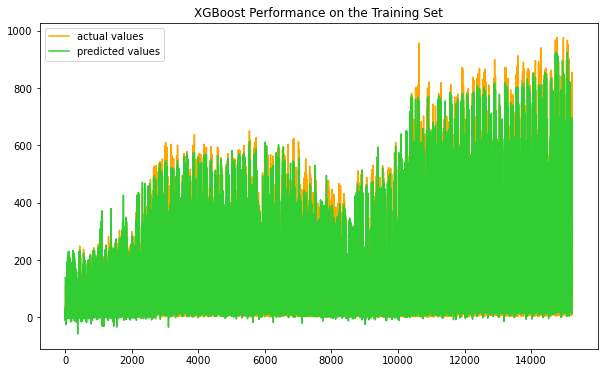

In [90]:
# we plot the predicted vs actual y_train values 

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y_train.values, label="actual values", c='orange')
ax.plot(y_hat, label="predicted values", c='limegreen')
plt.title("XGBoost Performance on the Training Set")
ax.legend()
plt.show()

<a id="22"></a>
## 4.2. Adjusting Learning Rate with Validation Curve

In [91]:
training_score, testing_score = validation_curve(xg, x_train_trans, y_train, param_name="learning_rate",param_range=[.02, .03, .04, .07, .09, 0.11, 0.13],cv=10)

On the training set, the algorithm nearly perfectly predicts the exact amount of bikes rented. Lets see how the validation curve behaves on the training data to see if there is a even better value for certain hyperparameters.

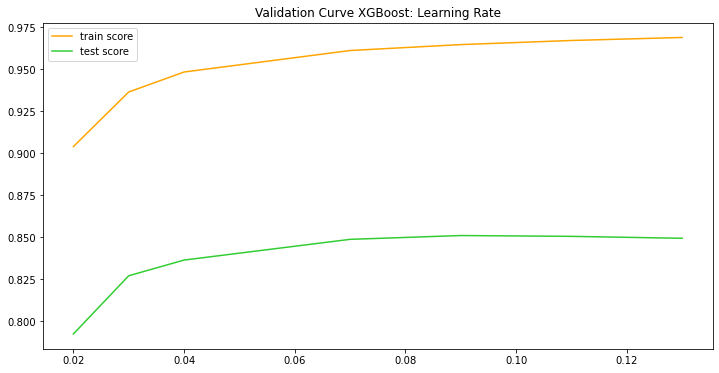

In [92]:
max_test_scores = np.argmax(testing_score.mean(axis=1)) # index at which max test score occurs
plt.figure(figsize=(12,6))
plt.plot([.02, .03, .04, .07, .09, .11, .13], training_score.mean(axis=1), label="train score", color='orange')  
plt.plot([.02, .03, .04, .07, .09, .11, .13], testing_score.mean(axis=1), label="test score", color='limegreen')
plt.title("Validation Curve XGBoost: Learning Rate")
plt.legend()
plt.show()

<a id="23" ></a>
## 4.3. Test the Final Model

Test the Algorithm with the new **best learning rate of 0.1**. Since our n_estimators is large we must use regularizers such as gamma = 20 and max_depth = 10 in order to avoid overfitting!

In [93]:
xg = XGBRegressor(learning_rate=.1, min_child_weight=20,n_estimators=600, gamma=20, max_depth=10)

xg.fit(x_train_trans, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=20, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=20, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [94]:
y_hat_new = xg.predict(x_test_trans)

In [95]:
# we obtain the performance metrics:

mse = mean_squared_error(y_test, y_hat_new)
r_2 = r2_score(y_test, y_hat_new)
 
print("Root RMSE on test set: {}".format(mse**0.5))
print("R^2 on test set: {}".format(round(r_2, 4)))

Root RMSE on test set: 69.35732353435752
R^2 on test set: 0.8816


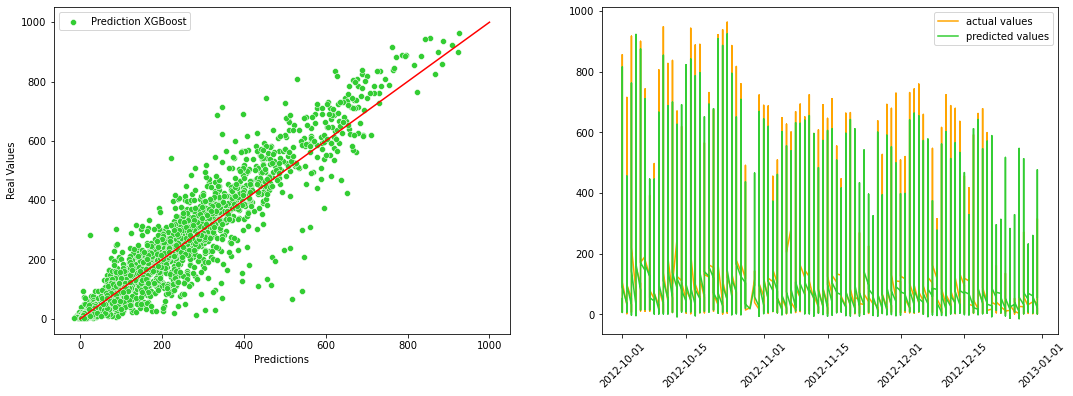

In [96]:

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
line = list(range(0, 1200, 200))

sns.scatterplot(x=y_hat_new, y=y_test, color='limegreen', ax=axes[0])


axes[1].plot(y_test.index, y_test.values, label="actual values", c='orange')
axes[1].plot(y_test.index, y_hat_new, label="predicted values", c='limegreen')
axes[1].legend()
axes[1].tick_params("x", rotation=45)
axes[0].plot(line, line, color="red")

axes[0].set_xlabel("Predictions")
axes[0].set_ylabel("Real Values")
axes[0].legend(["Prediction XGBoost"])

# we plot the predicted vs actual y_train values 

[Index](#index)